In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
import albumentations as A

In [3]:
# Define paths
base_dir = "C:/Users/Akoba/Desktop/START up/COMPUTER-AIDED-VISION-FOR-PLANT-DISEASE-DETECTION"
data_dir = os.path.join(base_dir, "Data/PlantVillage")
metadata_csv = os.path.join(base_dir, "Data/PlantVillage/metadata.csv")

In [4]:
# Set random seed for reproducibility
np.random.seed(42)

In [5]:
# Create directories for saving cleaned data
cleaned_dir = os.path.join(base_dir, "Data/PlantVillage/cleaned")
os.makedirs(cleaned_dir, exist_ok=True)

In [6]:
df = pd.read_csv(metadata_csv)
print("Dataset Overview:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print(f"\nTotal Images: {len(df)}")
print(f"Total Classes: {df['label'].nunique()}")
print("\nClasses:")
print(df['label'].unique())

Dataset Overview:
                                          image_path  \
0  C:/Users/Akoba/Desktop/START up/COMPUTER-AIDED...   
1  C:/Users/Akoba/Desktop/START up/COMPUTER-AIDED...   
2  C:/Users/Akoba/Desktop/START up/COMPUTER-AIDED...   
3  C:/Users/Akoba/Desktop/START up/COMPUTER-AIDED...   
4  C:/Users/Akoba/Desktop/START up/COMPUTER-AIDED...   

                           label  
0  Pepper__bell___Bacterial_spot  
1  Pepper__bell___Bacterial_spot  
2  Pepper__bell___Bacterial_spot  
3  Pepper__bell___Bacterial_spot  
4  Pepper__bell___Bacterial_spot  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20638 entries, 0 to 20637
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  20638 non-null  object
 1   label       20638 non-null  object
dtypes: object(2)
memory usage: 322.6+ KB
None

Total Images: 20638
Total Classes: 15

Classes:
['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy

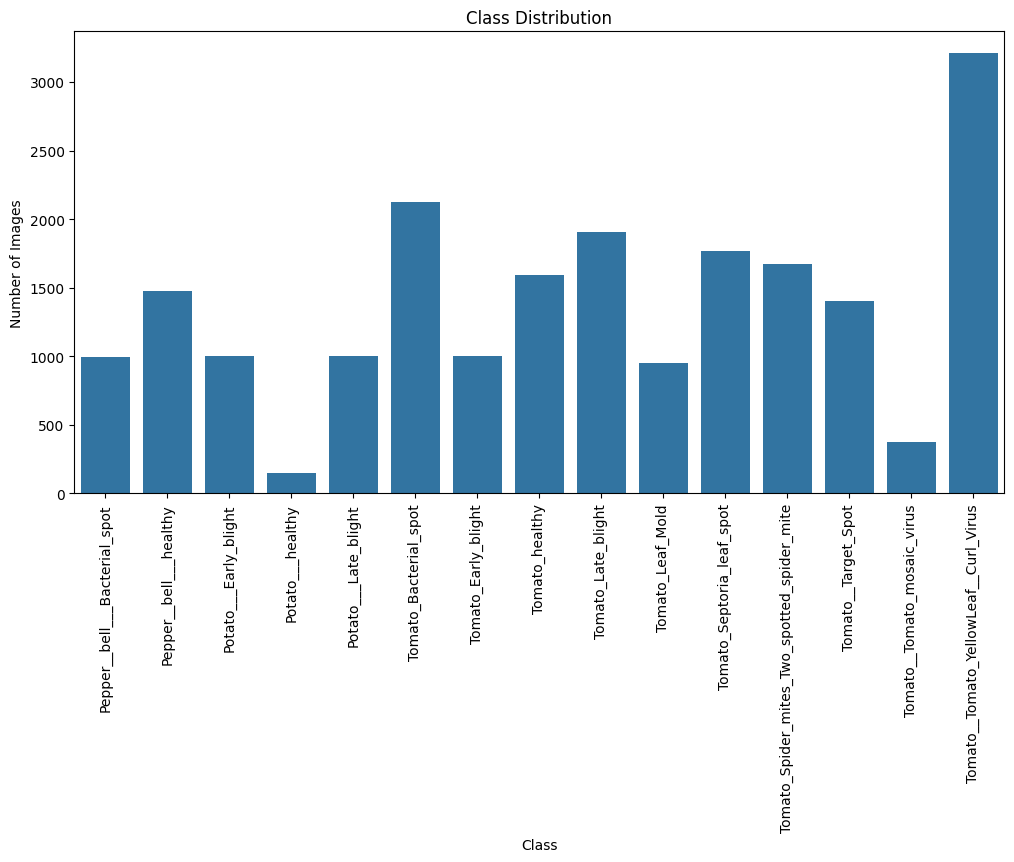

In [7]:
plt.figure(figsize=(12, 6))
sns.countplot(x="label", data=df)
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [8]:
# Print class counts
print("\nClass Counts:")
print(df["label"].value_counts())


Class Counts:
label
Tomato__Tomato_YellowLeaf__Curl_Virus          3208
Tomato_Bacterial_spot                          2127
Tomato_Late_blight                             1909
Tomato_Septoria_leaf_spot                      1771
Tomato_Spider_mites_Two_spotted_spider_mite    1676
Tomato_healthy                                 1591
Pepper__bell___healthy                         1478
Tomato__Target_Spot                            1404
Potato___Early_blight                          1000
Potato___Late_blight                           1000
Tomato_Early_blight                            1000
Pepper__bell___Bacterial_spot                   997
Tomato_Leaf_Mold                                952
Tomato__Tomato_mosaic_virus                     373
Potato___healthy                                152
Name: count, dtype: int64


In [9]:
def check_image_quality(img_path):
    try:
        # Load image with OpenCV
        img = cv2.imread(img_path)
        if img is None:
            return False, "Corrupted"
        
        # Convert to grayscale for blur detection
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Detect blur using Laplacian variance (low variance = blurry)
        laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        if laplacian_var < 100:  # Threshold for blur
            return False, "Blurry"
        
        # Check brightness (too dark or too bright)
        brightness = np.mean(img)
        if brightness < 30 or brightness > 225:  # Thresholds for brightness
            return False, "Too dark/bright"
        
        return True, "Good"
    except Exception as e:
        return False, f"Error: {str(e)}"

# Sample 100 images for quality check
sample_df = df.sample(n=min(100, len(df)), random_state=42)
quality_results = []
for img_path in sample_df["image_path"]:
    is_good, reason = check_image_quality(img_path)
    quality_results.append({"image_path": img_path, "is_good": is_good, "reason": reason})

quality_df = pd.DataFrame(quality_results)
print("\nImage Quality Check (Sample):")
print(quality_df["reason"].value_counts())

# Filter out bad images
bad_images = quality_df[quality_df["is_good"] == False]["image_path"]
print(f"\nNumber of bad images in sample: {len(bad_images)}")


Image Quality Check (Sample):
reason
Good      97
Blurry     3
Name: count, dtype: int64

Number of bad images in sample: 3


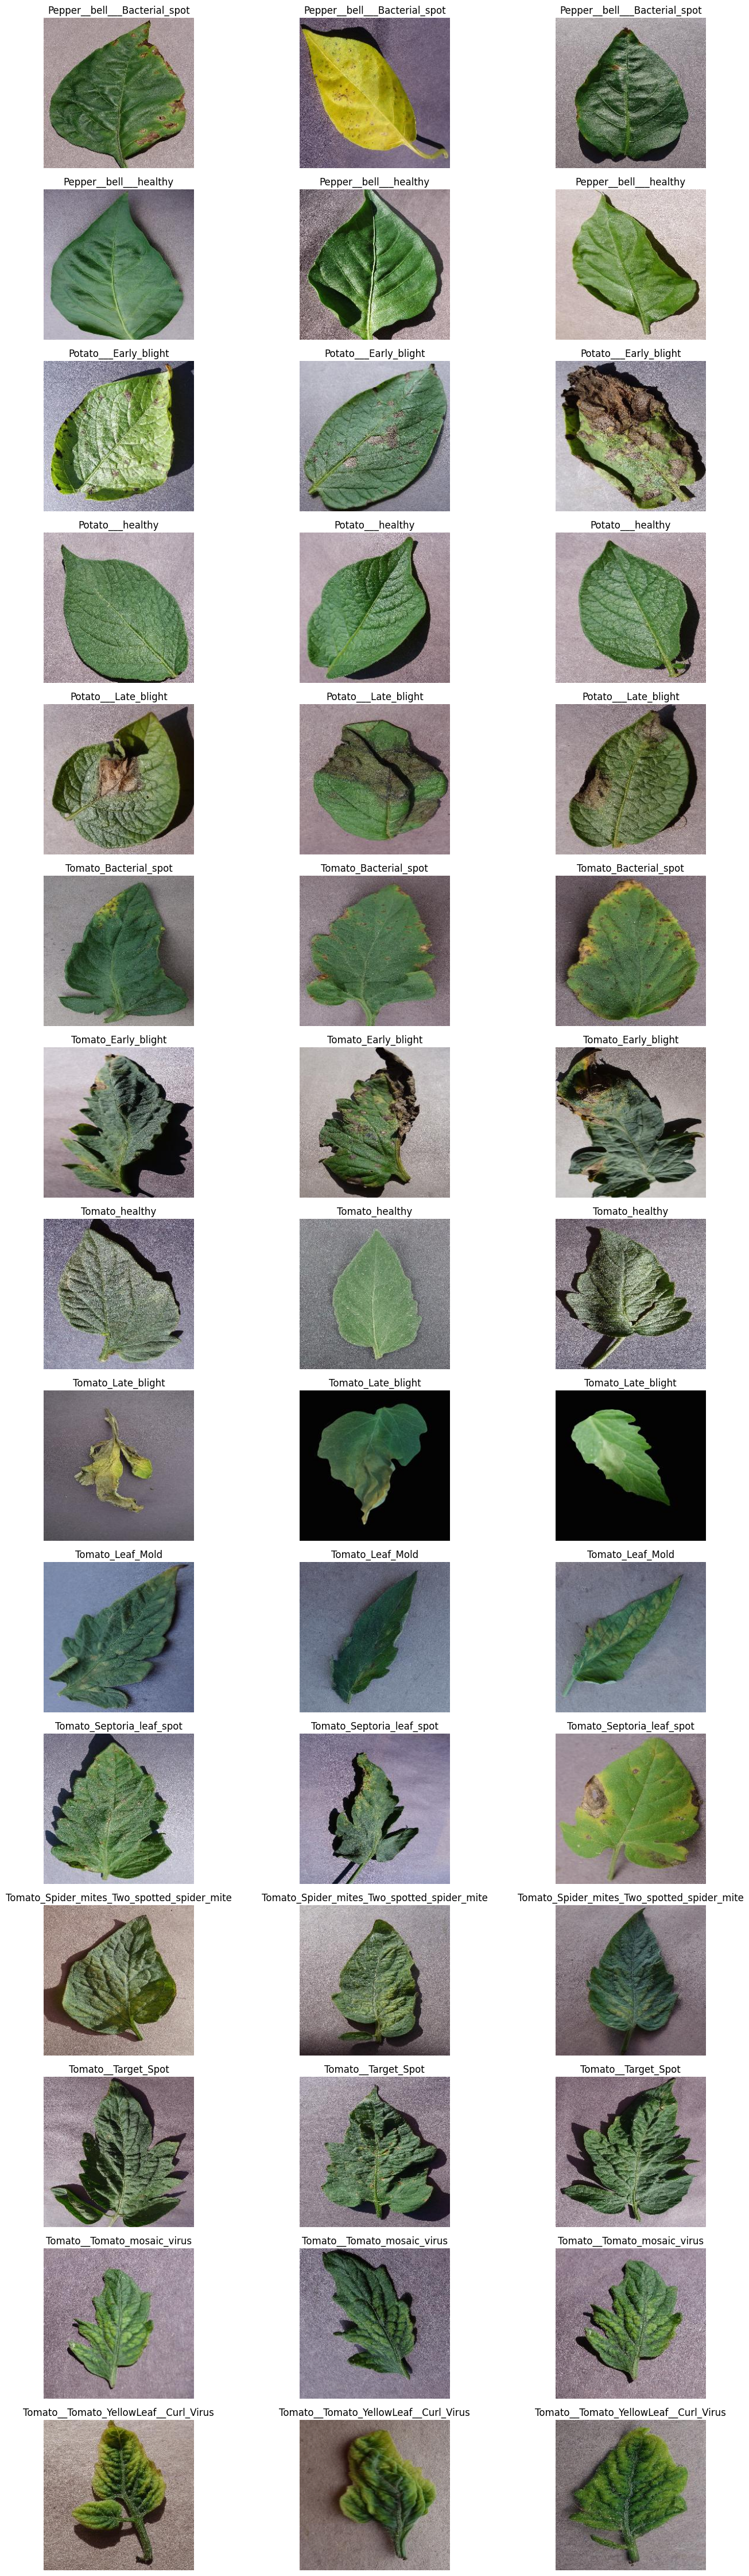

In [10]:
def plot_sample_images(df, num_samples=3):
    classes = df["label"].unique()
    plt.figure(figsize=(15, len(classes) * 3))
    for i, class_name in enumerate(classes):
        class_df = df[df["label"] == class_name].sample(n=min(num_samples, len(df[df["label"] == class_name])), random_state=42)
        for j, row in enumerate(class_df.itertuples()):
            img = Image.open(row.image_path)
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_sample_images(df)

Removed 943 bad images. Cleaned dataset size: 19695

Median class count: 1404.0
Balanced dataset size: 24051


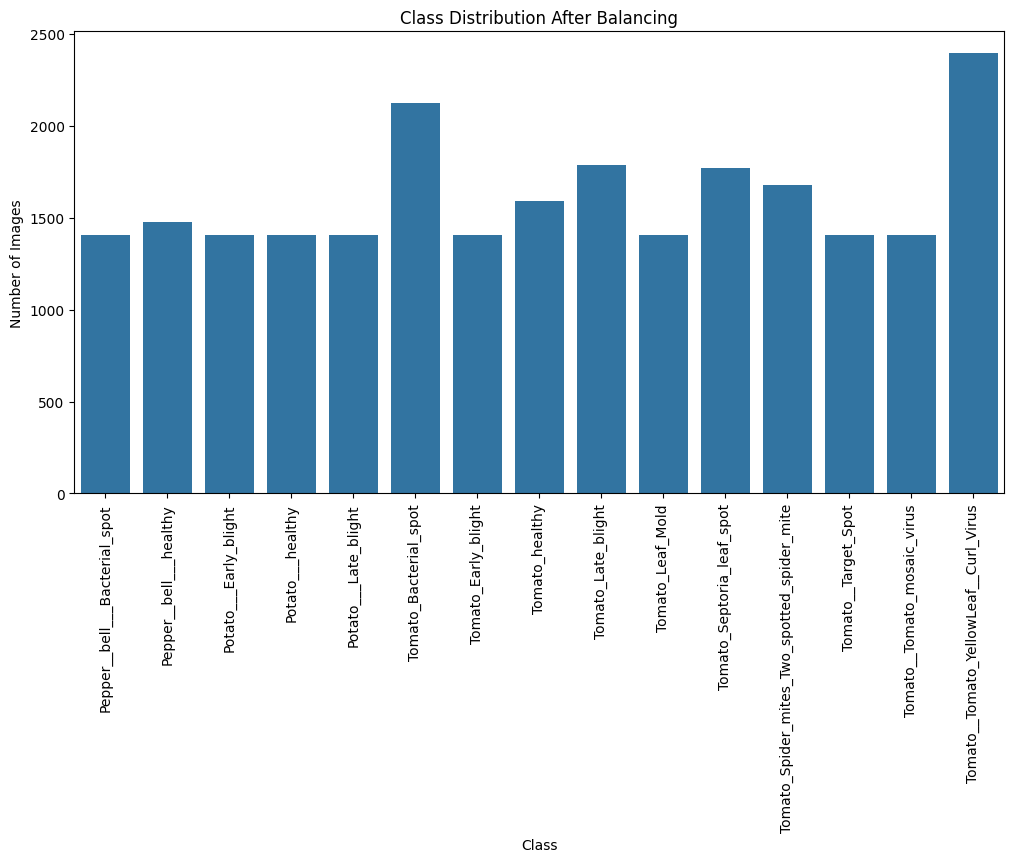

✅ Saved balanced_metadata.csv


In [11]:
# Remove bad images (apply to full dataset)
all_quality_results = []
for img_path in df["image_path"]:
    is_good, reason = check_image_quality(img_path)
    all_quality_results.append({"image_path": img_path, "is_good": is_good, "reason": reason})

quality_df_full = pd.DataFrame(all_quality_results)
bad_images_full = quality_df_full[quality_df_full["is_good"] == False]["image_path"]
cleaned_df = df[~df["image_path"].isin(bad_images_full)]
print(f"Removed {len(bad_images_full)} bad images. Cleaned dataset size: {len(cleaned_df)}")

# Balance the dataset (oversample minority classes)
class_counts = cleaned_df["label"].value_counts()
median_count = class_counts.median()
print(f"\nMedian class count: {median_count}")

# Oversample classes with fewer images than the median
balanced_dfs = []
for label in cleaned_df["label"].unique():
    class_df = cleaned_df[cleaned_df["label"] == label]
    if len(class_df) < median_count:
        # Oversample by repeating images
        oversampled_df = class_df.sample(n=int(median_count), replace=True, random_state=42)
        balanced_dfs.append(oversampled_df)
    else:
        balanced_dfs.append(class_df)

balanced_df = pd.concat(balanced_dfs).reset_index(drop=True)
print(f"Balanced dataset size: {len(balanced_df)}")

# Plot new class distribution
plt.figure(figsize=(12, 6))
sns.countplot(x="label", data=balanced_df)
plt.xticks(rotation=90)
plt.title("Class Distribution After Balancing")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

# Save cleaned and balanced dataset
balanced_df.to_csv(os.path.join(base_dir, "Data/PlantVillage/balanced_metadata.csv"), index=False)
print("✅ Saved balanced_metadata.csv")

In [12]:
train_df, temp_df = train_test_split(balanced_df, test_size=0.3, stratify=balanced_df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.33, stratify=temp_df["label"], random_state=42)

# Save splits
train_df.to_csv(os.path.join(base_dir, "Data/PlantVillage/train.csv"), index=False)
val_df.to_csv(os.path.join(base_dir, "Data/PlantVillage/val.csv"), index=False)
test_df.to_csv(os.path.join(base_dir, "Data/PlantVillage/test.csv"), index=False)

print(f"Train set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

Train set: 16835 images
Validation set: 4834 images
Test set: 2382 images


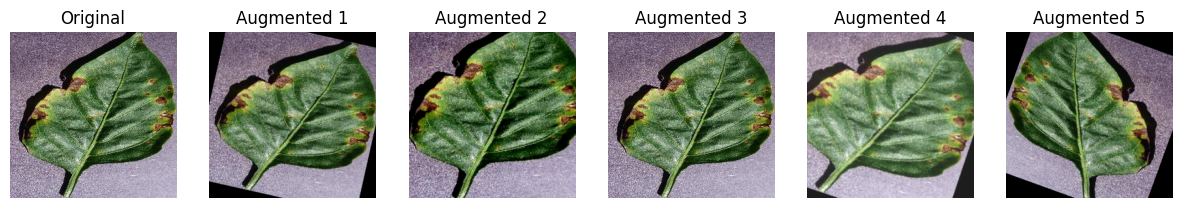

In [13]:
transform = A.Compose([
    A.Rotate(limit=30, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.RandomCrop(height=224, width=224, p=0.3),
    A.Resize(256, 256)  # Ensure final size is 256x256
])

# Pick a sample image
sample_img_path = balanced_df["image_path"].iloc[0]
img = cv2.imread(sample_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Apply augmentation 5 times
plt.figure(figsize=(15, 3))
plt.subplot(1, 6, 1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

for i in range(5):
    augmented = transform(image=img)["image"]
    plt.subplot(1, 6, i + 2)
    plt.imshow(augmented)
    plt.title(f"Augmented {i+1}")
    plt.axis("off")
plt.show()